# (05) Trainers (KABA)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
path = results_dir()
path = pathlib.Path(path)

trainer_paths = set()
pattern = '**/Trainer' # '**/*fixate1*/**/Trainer'
for p in path.rglob(pattern):
    if p.is_dir():
        trainer_paths.add(str(p))
trainer_paths = sorted(trainer_paths)
len(trainer_paths)

49

In [3]:
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if not os.path.isfile(f):
        print(f, os.path.isfile(f))

In [4]:
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if os.path.isfile(f):
        continue
    print('~' * 12 + '   fit name :   ' + '~' * 12)
    print(fit_name)
    print('-' * 40)
    tr, _ = load_model_lite(fit_path, 'cuda:0')
    all_norms = to_np(torch.cat(
        tr.model.all_lognorm).exp())
    avg_norms = all_norms.mean()

    fig, ax = create_figure(1, 1, (5, 2.5))
    sns.histplot(all_norms, bins=np.linspace(0.5, 1.5, 101), ax=ax)
    ax.axvline(avg_norms, color='r', ls='--', lw=1.2, label=f'avg = {avg_norms:0.3f}')
    title = f"sim = {tr.model.cfg.sim},   " + r"$\beta$ = " + f"{tr.cfg.kl_beta}"
    ax.set_title(title, fontsize=12)
    ax.legend()
    plt.show()

    msg = f"{tr.model.cfg.sim}:\tbeta = {tr.cfg.kl_beta},\t"
    
    if isinstance(tr, TrainerVAE):
        val, loss = tr.validate(use_ema=False)
        data_trn, _ = tr.forward('trn', freeze=True, use_ema=False)
        data_vld, _ = tr.forward('vld', freeze=True, use_ema=False)
        data_tst, _ = tr.forward('tst', freeze=True, use_ema=False)
        msg += f"NELBO: {loss['epe'].mean() + loss['kl'].mean():0.2f}"
    else:
        val, loss = tr.validate(use_ema=False)
        data_trn, _ = tr.forward('trn', use_ema=False)
        data_vld, _ = tr.forward('vld', use_ema=False)
        data_tst, _ = tr.forward('tst', use_ema=False)
        msg += f"EPE: {loss['epe'].mean():0.2f}"

    print(msg)
    print({k: v.mean() for k, v in loss.items()})

    # regress
    f = tr.dl_vld.dataset.f + tr.dl_vld.dataset.f_aux
    g = np.concatenate([
        tr.dl_vld.dataset.g,
        tr.dl_vld.dataset.g_aux,
    ], axis=1)
    g_tst = np.concatenate([
        tr.dl_tst.dataset.g,
        tr.dl_tst.dataset.g_aux,
    ], axis=1)

    shape = (len(f), data_vld['z'].shape[1])
    importances_mu = np.zeros(shape)
    importances_sd = np.zeros(shape)

    for i in tqdm(range(len(f)), leave=False):
        _lr = sk_linear.LinearRegression().fit(
            data_vld['z'], g[:, i])
        result = sk_inspect.permutation_importance(
            estimator=_lr,
            X=data_tst['z'],
            y=g_tst[:, i],
            n_repeats=5,
            random_state=0,
        )
        importances_mu[i] = result.importances_mean
        importances_sd[i] = result.importances_std

    everything = {
        'val': val,
        'loss': loss,
        'data_trn': data_trn,
        'data_vld': data_vld,
        'data_tst': data_tst,
        'importances_mu': importances_mu,
        'importances_sd': importances_sd,
        'f': f,
    }
    save_obj(
        obj=everything,
        file_name=fit_name,
        save_dir=pjoin(tmp_dir, 'trainer_analysis'),
        verbose=True,
        mode='npy',
    )

    torch.cuda.empty_cache()

In [5]:
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if not os.path.isfile(f):
        print(f, os.path.isfile(f))

---
---

## Old code

---

In [3]:
fit_name = trainer_paths[0]
tr, _ = load_model_lite(fit_name, 'cuda:2')

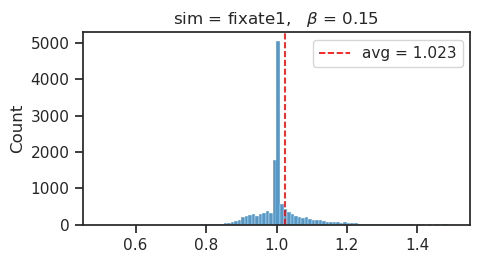

In [4]:
all_norms = to_np(torch.cat(
    tr.model.all_lognorm).exp())
avg_norms = all_norms.mean()

fig, ax = create_figure(1, 1, (5, 2.5))
sns.histplot(all_norms, bins=np.linspace(0.5, 1.5, 101), ax=ax)
ax.axvline(avg_norms, color='r', ls='--', lw=1.2, label=f'avg = {avg_norms:0.3f}')
title = f"sim = {tr.model.cfg.sim},   " + r"$\beta$ = " + f"{tr.cfg.kl_beta:0.2f}"
ax.set_title(title, fontsize=12)
ax.legend()
plt.show()

In [ ]:
val, loss = tr.validate(use_ema=False)
print({k: v.mean() for k, v in loss.items()})

In [10]:
msg = f"{tr.model.cfg.sim}:\tbeta = {tr.cfg.kl_beta},\t"
msg += f"ELBO: {loss['epe'].mean() + loss['kl'].mean():0.2f}"
print(msg)

fixate1:        beta = 0.15,    ELBO: 38.87

In [5]:
%%time

data, loss = tr.forward('vld', freeze=False, use_ema=False)
data_trn, _ = tr.forward('trn', freeze=True, use_ema=False)
data_vld, _ = tr.forward('vld', freeze=True, use_ema=False)
data_tst, _ = tr.forward('tst', freeze=True, use_ema=False)

CPU times: user 5min 24s, sys: 37.6 s, total: 6min 2s
Wall time: 6min 1s


In [40]:
loss['epe'].mean(), loss['kl'].mean(), loss['kl_diag'].sum()

(1.7706264, 37.097996, 37.097996)

In [7]:
loss['epe'].mean() + loss['kl'].mean()

38.86862

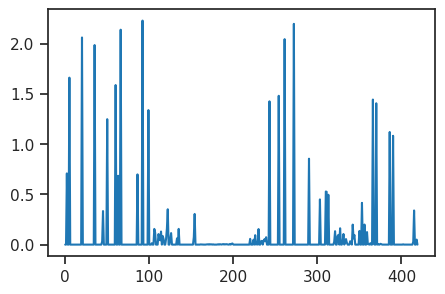

In [20]:
plt.plot(loss['kl_diag'])

In [35]:
active = loss['kl_diag'] > 0.1
active.sum()

44

In [36]:
max(loss['kl_diag'])

2.22859

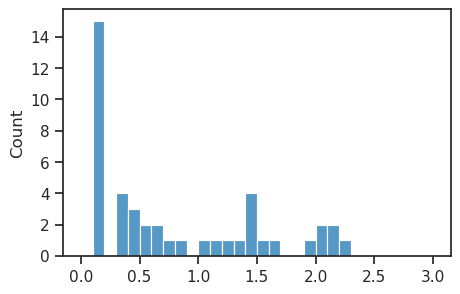

In [37]:
sns.histplot(loss['kl_diag'][loss['kl_diag'] > 0.1], bins=np.linspace(0, 3, 31));

37.097996

In [8]:
list(data_trn)

['x', 'y', 'z']

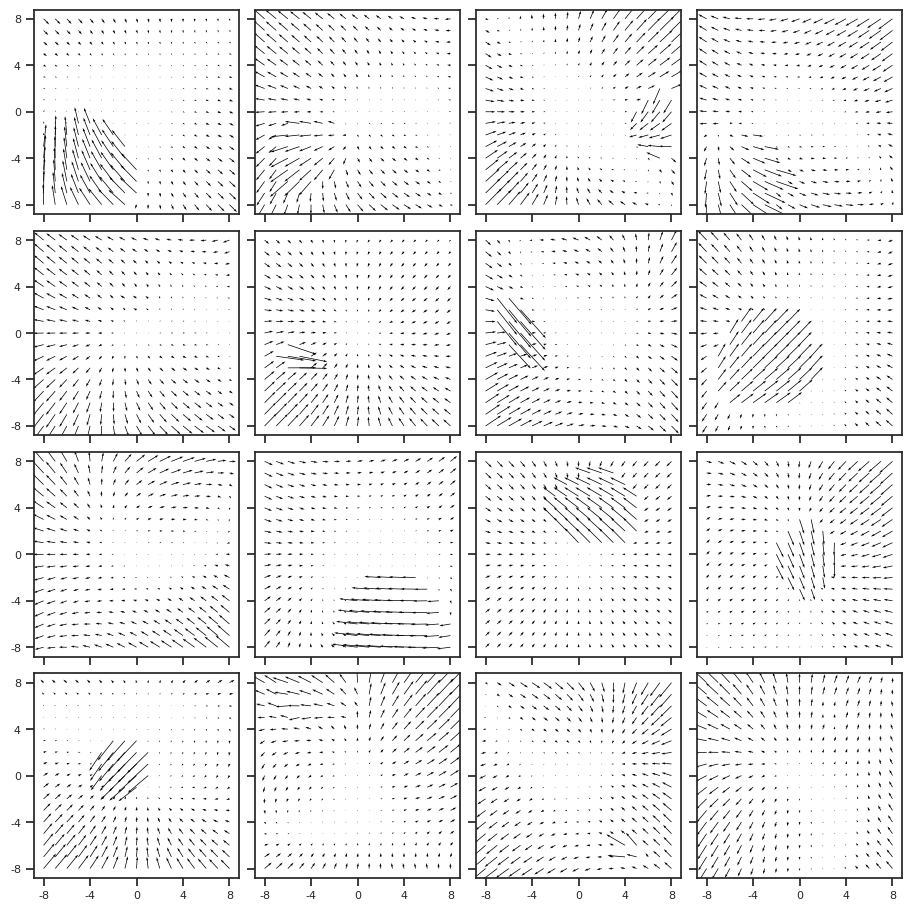

In [9]:
show_opticflow(data_trn['x']);

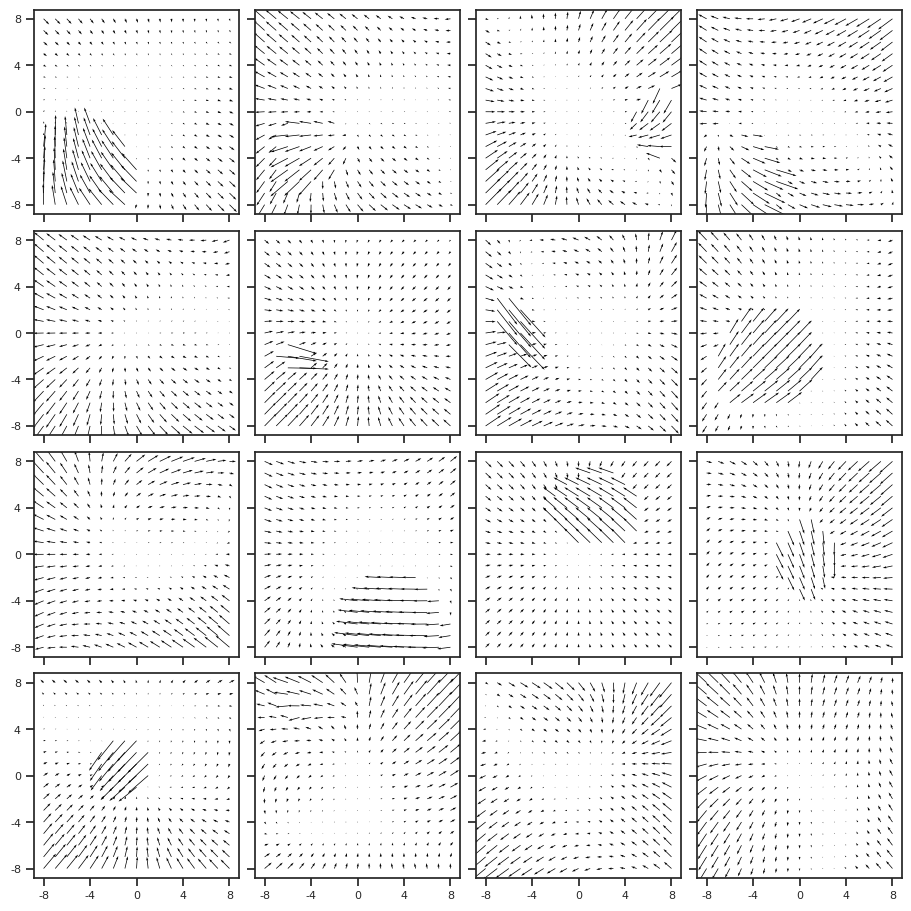

In [10]:
show_opticflow(data_trn['y']);

In [11]:
f = tr.dl_vld.dataset.f + tr.dl_vld.dataset.f_aux
g = np.concatenate([
    tr.dl_vld.dataset.g,
    tr.dl_vld.dataset.g_aux,
], axis=1)
g_tst = np.concatenate([
    tr.dl_tst.dataset.g,
    tr.dl_tst.dataset.g_aux,
], axis=1)
len(f), g.shape, g_tst.shape

(33, (75000, 33), (75000, 33))

In [13]:
lr = sk_linear.LinearRegression().fit(data_vld['z'], g)
pred = lr.predict(data_tst['z'])
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=pred,
    multioutput='raw_values',
)
print(r2.mean(), '\n\n', list(zip(f, np.round(r2 * 100, 1))))

0.8376012219256262 


[
    ('fix_x', 99.0),
    ('fix_y', 99.1),
    ('slf_v_norm', 98.4),
    ('slf_v_theta', 80.9),
    ('slf_v_phi', 59.8),
    ('obj0_alpha_x', 95.5),
    ('obj0_alpha_y', 95.1),
    ('obj0_distance', 92.9),
    ('obj0_v_norm', 70.8),
    ('obj0_v_theta', 53.1),
    ('obj0_v_phi', 39.1),
    ('slf_v_x', 99.0),
    ('slf_v_y', 96.1),
    ('slf_v_z', 99.6),
    ('obj0_size_eff', 98.8),
    ('obj0_size', 98.8),
    ('obj0_theta', 96.4),
    ('obj0_phi', 82.6),
    ('obj0_x', 93.4),
    ('obj0_y', 93.0),
    ('obj0_z', 84.7),
    ('obj0_dx', 92.0),
    ('obj0_dy', 91.2),
    ('obj0_dz', 84.7),
    ('obj0_v_x', 73.7),
    ('obj0_v_y', 81.8),
    ('obj0_v_z', 68.3),
    ('obj0_dv_x', 86.4),
    ('obj0_dv_y', 89.5),
    ('obj0_dv_z', 84.0),
    ('obj0_dv_norm', 64.8),
    ('obj0_dv_theta', 72.6),
    ('obj0_dv_phi', 49.1)
]

In [33]:
shape = (len(f), data_vld['z'].shape[1])
importances = np.zeros(shape)
importances_sd = np.zeros(shape)

for i in tqdm(range(len(f))):
    _lr = sk_linear.LinearRegression().fit(
        data_vld['z'], g[:, i])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=data_tst['z'],
        y=g_tst[:, i],
        n_repeats=5,
        random_state=0,
    )
    importances[i] = result.importances_mean
    importances_sd[i] = result.importances_std

100%|██████████| 33/33 [55:08<00:00, 100.27s/it]


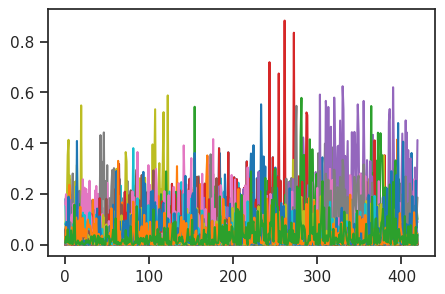

In [124]:
test = importances.copy()
test = np.maximum(0, test)
test /= test.sum(0, keepdims=True)
plt.plot(test.T);

In [126]:
sum(test[:, 1])

0.9999999999999997

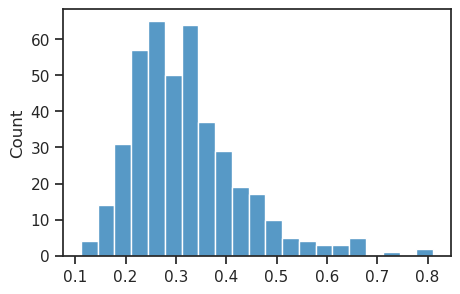

In [134]:
ddd = 1 - entropy_normalized(test, axis=0)
sns.histplot(ddd);

In [142]:
selected = [0, 1, 11, 12, 13, 5, 6, 15, 24, 25, 26]

In [143]:
list(np.array(f)[selected])

['fix_x',
 'fix_y',
 'slf_v_x',
 'slf_v_y',
 'slf_v_z',
 'obj0_alpha_x',
 'obj0_alpha_y',
 'obj0_size',
 'obj0_v_x',
 'obj0_v_y',
 'obj0_v_z']

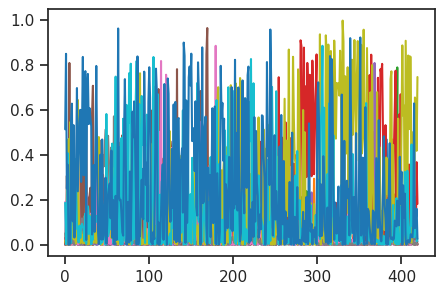

In [145]:
test = importances[selected].copy()
test = np.maximum(0, test)
test /= test.sum(0, keepdims=True)
plt.plot(test.T);

In [147]:
test.shape

(11, 420)

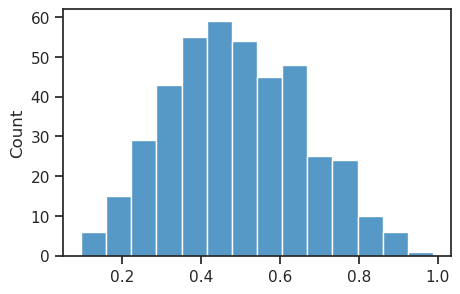

In [148]:
ddd = 1 - entropy_normalized(test, axis=0)
sns.histplot(ddd);

In [149]:
ddd.mean()

0.49046137188766764

(420,)

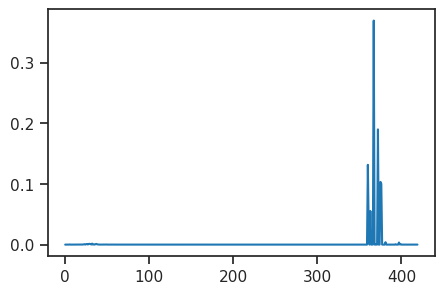

In [155]:
rho = importances[selected].copy()
rho = np.maximum(0, rho)
rho = rho.sum(0) / rho.sum()
plt.plot(rho)
rho.shape

In [159]:
sum(rho * ddd)

0.4982127125315644

In [161]:
w = importances[selected].copy()
w = np.maximum(0, w)
compute_dci(w)

(0.4982127125315644, 0.7045368172610267)

In [162]:
w.shape

(11, 420)

'obj0_alpha_x'

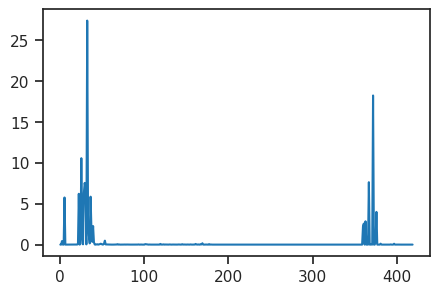

In [200]:
ii = 5
plt.plot(w[ii])
list(np.array(f)[selected])[ii]

In [201]:
x, _ = next(iter(tr.dl_tst))

In [210]:
y, z, q, p, *_ = tr.model.xtract_ftr(x=x, t=1.0)

In [211]:
kl_all, diag = tr.model.loss_kl(q, p)

In [212]:
sum(diag)

tensor([3.7912e+00, 2.3248e+00, 1.2640e+00, 2.6034e+00, 2.4253e-01, 2.1635e+00,
        5.8895e+00, 3.2736e-01, 3.5474e-02, 3.7212e-03, 5.5269e+00, 7.4382e-01,
        4.4674e+00, 1.1583e+00, 2.0484e+00, 2.4368e+00, 3.2072e-01, 1.0108e-01,
        9.5472e-02, 1.5318e+00], device='cuda:2')

In [227]:
torch.cat(diag).unsqueeze(0).shape

torch.Size([1, 420])

In [219]:
to_np(sum(kl_all)).shape

(600,)

In [221]:
len(kl_all)

21

In [222]:
kl_all[0].shape

torch.Size([600])

In [225]:
sum(diag).shape

torch.Size([20])

## TODO: Loop --> Save results in tmp_dir/trainer_analysis

## Pickling didn't work

In [2]:
path = results_dir()
path = pathlib.Path(path)

fit_names = set()
for p in path.rglob('**/*fixate1_*'):
    if p.is_dir():
        fit_names.add(p.name)
fit_names = sorted(fit_names)
print(fit_names)

[
    'fixate1_nf-420_(2023_04_27,20:20)',
    'fixate1_nf-420_beta-0.01_(2023_04_30,07:42)',
    'fixate1_nf-420_beta-0.1_(2023_04_29,22:01)',
    'fixate1_nf-420_beta-0.2_(2023_04_30,21:37)',
    'fixate1_nf-420_beta-0.5_(2023_04_30,20:05)',
    'fixate1_nf-420_beta-0.6_(2023_04_30,20:36)',
    'fixate1_nf-420_beta-0.7_(2023_04_30,21:40)',
    'fixate1_nf-420_beta-1.0_(2023_04_29,19:41)',
    'fixate1_nf-420_beta-1e+01_(2023_04_30,22:48)',
    'vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15)'
]

fixate1_nf-420_(2023_04_27,20:20)

Not Found

fixate1_nf-420_beta-0.01_(2023_04_30,07:42)

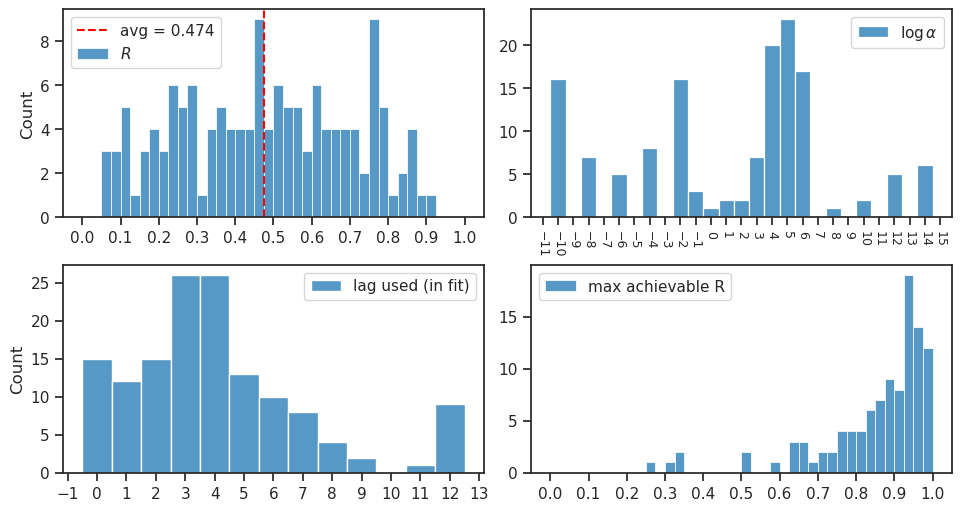

141

fixate1_nf-420_beta-0.1_(2023_04_29,22:01)

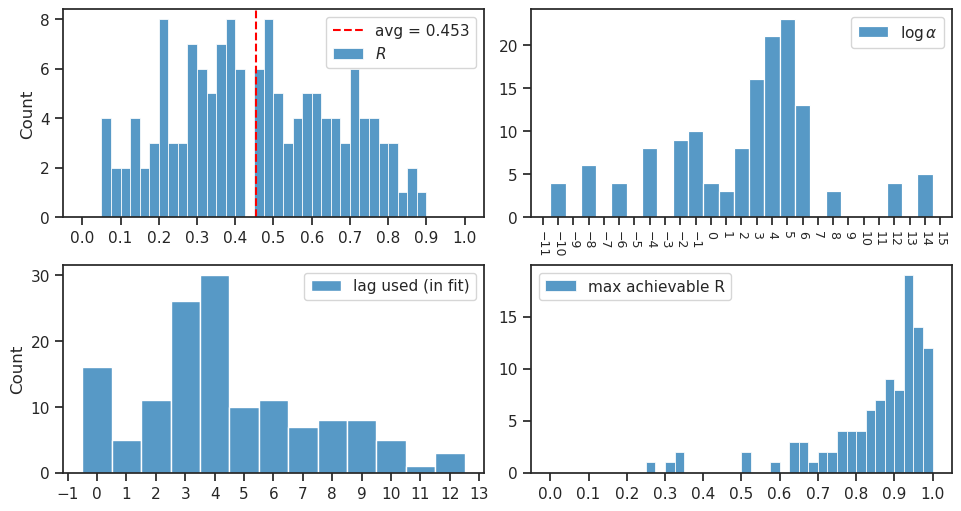

141

fixate1_nf-420_beta-0.2_(2023_04_30,21:37)

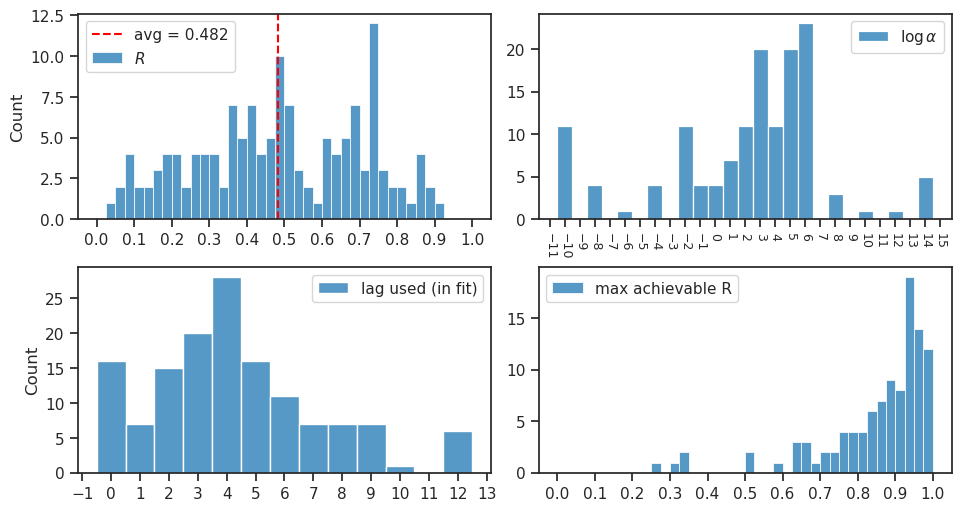

141

fixate1_nf-420_beta-0.5_(2023_04_30,20:05)

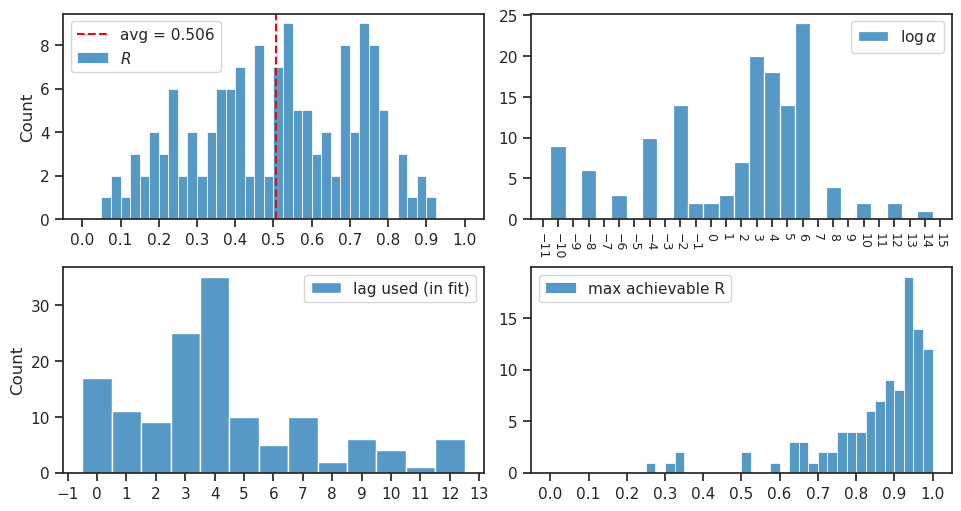

141

fixate1_nf-420_beta-0.6_(2023_04_30,20:36)

Not Found

fixate1_nf-420_beta-0.7_(2023_04_30,21:40)

Not Found

fixate1_nf-420_beta-1.0_(2023_04_29,19:41)

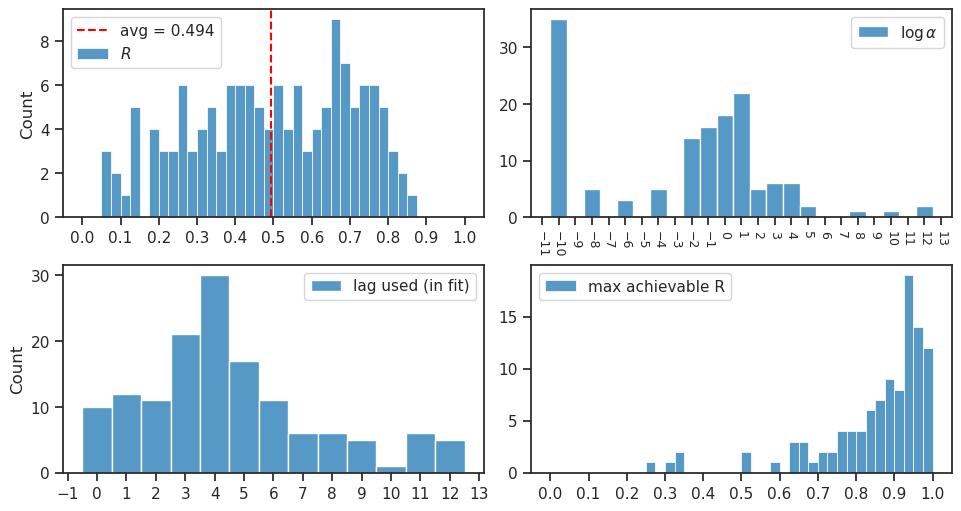

141

fixate1_nf-420_beta-1e+01_(2023_04_30,22:48)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid r

Not Found

vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15)

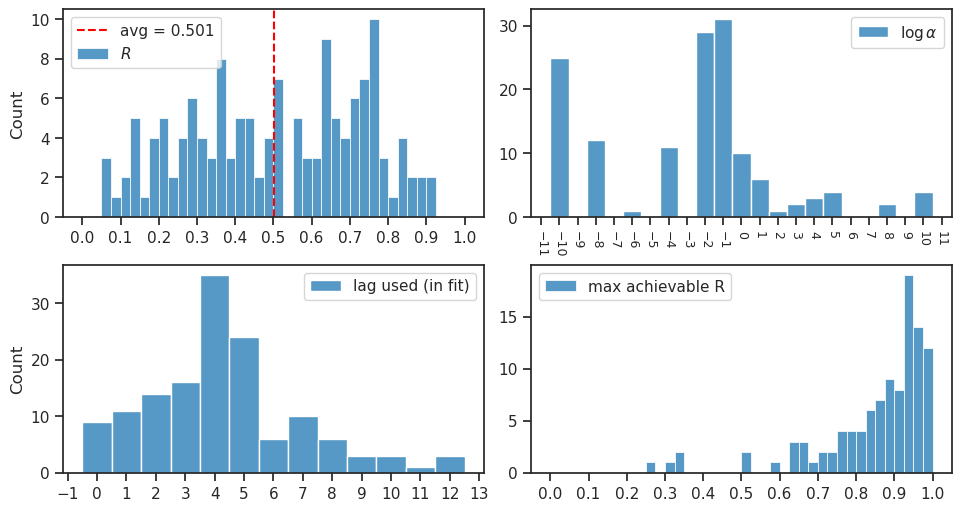

141

In [3]:
for f in fit_names:
    path = results_dir(f)
    print(f)
    try:
        df, df_all, ro_all, args, tr = summarize_neural_fits(f)
        _ = show_neural_results(df)
        print(len(df))
    except ModuleNotFoundError:
        print('Not Found')

In [31]:
path = results_dir()
path = pathlib.Path(path)

trainer_paths = set()
for p in path.rglob('**/*fixate1*/**/Trainer'):
    if p.is_dir():
        trainer_paths.add(str(p))
trainer_paths = sorted(trainer_paths)
trainer_paths

['/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_(2023_04_27,20:20)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-0.01_(2023_04_30,07:42)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-0.1_(2023_04_29,22:01)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-0.2_(2023_04_30,21:37)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-0.5_(2023_04_30,20:05)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-0.6_(2023_04_30,20:36)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-0.7_(2023_04_30,21:40)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-1.0_(2023_04_29,19:41)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_beta-1e+01_(2023_04_30,22:48)/Trainer',
 '/home/hadi/Documents/MTMST/results/Ridge/vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15)/Trainer']

In [33]:
load_model_lite(trainer_paths[0], 'cuda:2')

(<vae.train_vae.TrainerVAE at 0x7f1864313b50>,
 {'checkpoint': None,
  'global_step': None,
  'file': 'VAE+TrainerVAE_(2023_04_27,20:20).pt',
  'path': '/home/hadi/Documents/MTMST/results/Ridge/fixate1_nf-420_(2023_04_27,20:20)/Trainer'})